In [1]:
import time
import numpy as np
from tqdm import tqdm
import gymnasium as gym
from collections import defaultdict
from matplotlib import pyplot as plt

In [2]:
class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float, 
        final_epsilon: float,
        discount_factor: float=0.95,
    ):
        """
            Initialize a RL agent with an empty dictionary of state-action values (q_values),
            a learning rate and an epsilon.
            
            Args:
                env: The training environment
                learning_rate: The learning rate
                initial_epsilon: The initial epsilon value
                epsilon_decay: The decay for epsilon
                final_epsilong: The final epsilon value
                discount_factor: The discount factor for computing the Q-value
        """
        self.env      = env
        
        self.q_values        = defaultdict(lambda: np.zeros(env.action_space.n))

        self.discount_factor = discount_factor

        self.lr = learning_rate

        self.epsilon       = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []
    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
            Returns the best actions with probability (1 - epsilon)
            otherwise a random action with probability epsilon to ensure exploration.
        """

        # with probability epsilon return a action to explore the enviroment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """
            Updates the Q-value of an action.
        """
        
        future_q_value = (not terminated)*np.max(self.q_values[next_obs])
        temporal_difference = reward + self.discount_factor*future_q_value - self.q_values[obs][action]

        self.q_values[obs][action] = self.q_values[obs][action] + self.lr*temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon, self.epsilon - epsilon_decay)

In [3]:
#hyperparameters
learning_rate  = 0.01
n_episodes     = 100_000
start_epsilon = 1.0
epsilon_decay  = start_epsilon/(n_episodes/2) # reduce the exploration over time
final_epsilon  = 0.1

env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [4]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the env is done an the current obs
        done = terminated or truncated
        obs  = next_obs

    agent.decay_epsilon()

env.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:03<00:00, 1579.01it/s]


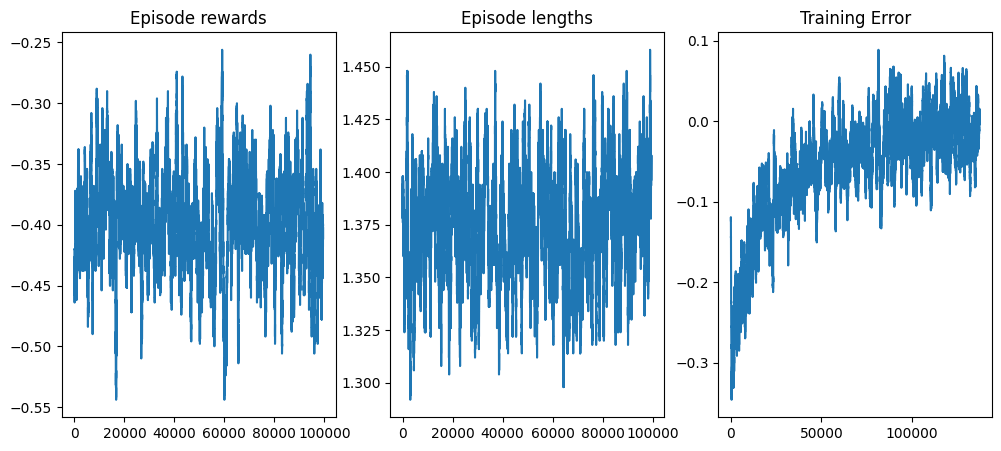

In [5]:
def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    )/window

# Smooth over a 500 episode episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12,5))

axs[0].set_title("Episode rewards")
reward_moving_average=get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid",
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.show()